___
# **Starter code for BME 5710 project**
## Instructor -- Rizwan Ahmad (ahmad.46@osu.edu)
## BME5710 -- Spring 2024

___
### Import libraries and sub-libraries.

In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF
import tifffile 

___
### Calling a custom code to change the default font for figures to `Computer Modern`. (Optional)

In [2]:
from fontsetting import font_cmu
plt = font_cmu(plt)

___
### Check the hardware that is at your disposal

In [3]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
print('Device available:', device)

Device available: cpu


___
### Read training data from `data/train-clean-tif`


In [4]:
# Loading TIFF images
class TIFFDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.filenames = [f for f in os.listdir(directory) if f.endswith('.tif')]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.filenames[idx])
        image = Image.open(img_path)
        if self.transform: # Dynamically apply data transformation
            image = self.transform(image)
        return image

# Create a transform to convert the images to PyTorch tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset for training images
train_dataset = TIFFDataset('train-clean-tif', transform=transform)

# Function to create data loader
def create_loader(train_dataset, batch_size):
    torch.manual_seed(0)  # For reproducibility of random numbers in PyTorch
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Creates a training DataLoader from this Dataset
    return train_loader

dataset_size = len(train_dataset)
print('Number of images in the dataset:', dataset_size)


Number of images in the dataset: 52


___
### Define a denoising network

#### Here, I have defined a trivial network, which has only one convolutional layer and no activation function. We are essentially doing linear filtering.

In [5]:
class TrivialNet(nn.Module):
    def __init__(self):
        super(TrivialNet, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

___
### Create a function to execute training. Note, we will call this function later.

In [6]:
def train_model(model, opt, criterion, train_loader, num_epoch, noise_std):
    avg_train_losses = []

    for epoch in range(num_epoch): # Loop over the dataset multiple times
        model.train()
        total_train_loss = 0
        for i, y_tr_batch in enumerate(train_loader): # Loop over mini-batches
            noise = torch.randn_like(y_tr_batch) * noise_std
            x_tr_batch = y_tr_batch + noise

            opt.zero_grad() # delete previous gradients
            y_hat_tr_batch = model(x_tr_batch) # forward pass
            loss = criterion(y_hat_tr_batch, y_tr_batch) # compute loss
            loss.backward() # backward pass
            opt.step() # update weights
            total_train_loss += loss.item() # accumulate loss
            if (i + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Iteration {i+1}, Loss: {loss.item():.6f}')

        avg_train_loss = total_train_loss / len(train_loader) # compute average loss
        avg_train_losses.append(avg_train_loss) # accumulate average loss

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(range(1, num_epoch+1), avg_train_losses, label='training loss')
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE loss')
    ax.set_yscale('log')  # Set the vertical axis to log scale
    ax.set_title('training loss')
    ax.grid(True)
    ax.legend()
    plt.show()

___
### Now, let us define hyperparameters and train the network. 

#### Note, in addition to the parameters that controls the network architecture or the training process, you need to select/initialize (i) a data loader, (ii) a model, (iii) an optimizer, and (iv) a loss function.

Epoch 1, Iteration 10, Loss: 0.041553
Epoch 1, Iteration 20, Loss: 0.043858
Epoch 2, Iteration 10, Loss: 0.023422
Epoch 2, Iteration 20, Loss: 0.016568
Epoch 3, Iteration 10, Loss: 0.013391
Epoch 3, Iteration 20, Loss: 0.014324
Epoch 4, Iteration 10, Loss: 0.014962
Epoch 4, Iteration 20, Loss: 0.011374
Epoch 5, Iteration 10, Loss: 0.009194
Epoch 5, Iteration 20, Loss: 0.010233
Epoch 6, Iteration 10, Loss: 0.009816
Epoch 6, Iteration 20, Loss: 0.008021
Epoch 7, Iteration 10, Loss: 0.007406
Epoch 7, Iteration 20, Loss: 0.006802
Epoch 8, Iteration 10, Loss: 0.006272
Epoch 8, Iteration 20, Loss: 0.007547
Epoch 9, Iteration 10, Loss: 0.006049
Epoch 9, Iteration 20, Loss: 0.006055
Epoch 10, Iteration 10, Loss: 0.005734
Epoch 10, Iteration 20, Loss: 0.005637
Epoch 11, Iteration 10, Loss: 0.004857
Epoch 11, Iteration 20, Loss: 0.004642
Epoch 12, Iteration 10, Loss: 0.004693
Epoch 12, Iteration 20, Loss: 0.004537
Epoch 13, Iteration 10, Loss: 0.004346
Epoch 13, Iteration 20, Loss: 0.004167
Epoc

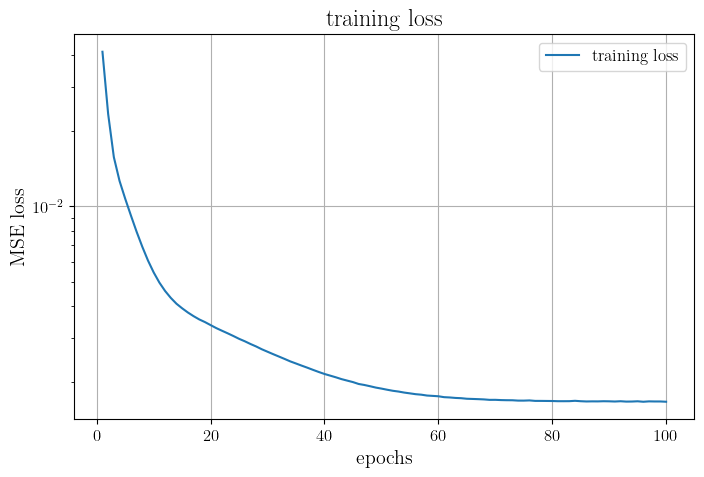

In [7]:
batch_size = 2  # Number of complete images in each batch
lr = 1e-3  # Learning rate
sig = 0.1  # Noise std
num_epoch = 100  # Epochs

# Model, criterion, and optimizer
train_loader = create_loader(train_dataset, batch_size)
model = TrivialNet() # Pick a model
opt = optim.Adam(model.parameters(), lr=lr) # Pick an optimizer
criterion = nn.MSELoss() # Pick a loss function

# Let's train the model
train_model(model, opt, criterion, train_loader, num_epoch, noise_std=sig)

___
### Apply it to one of the validation image

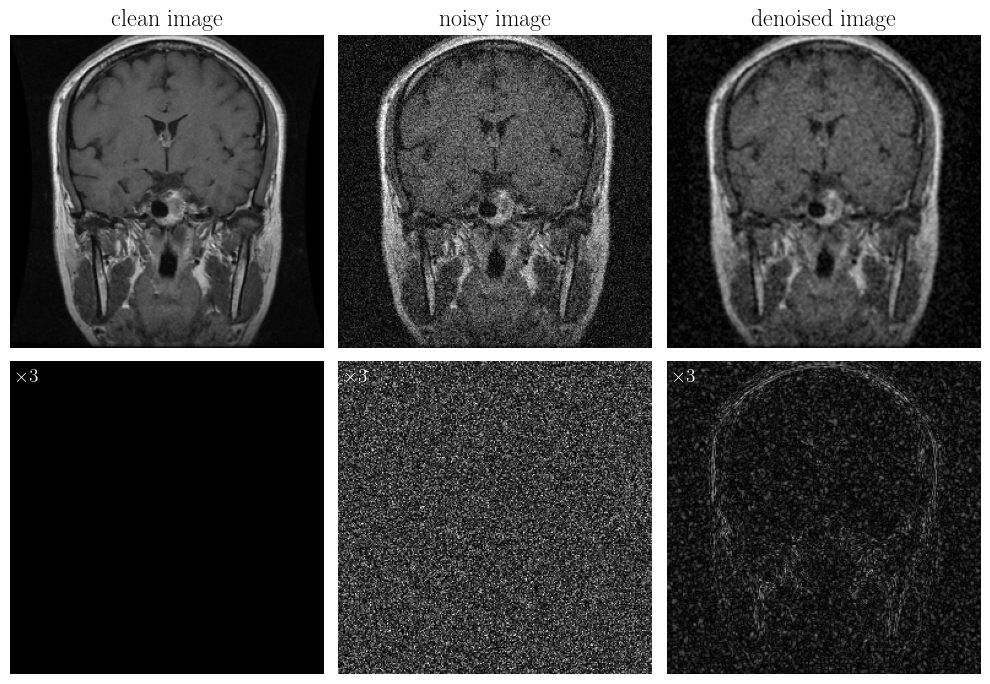

In [8]:
val_dataset = TIFFDataset('val-clean-tif', transform=transform) # Create the dataset for validation images
val_clean = val_dataset[0] # Load one clean image from the validation dataset
val_noisy = val_clean + (torch.randn_like(val_clean) * sig) # Add noise to the clean image
val_denoised = model(val_noisy).detach() # Denoise the noisy image using the trained model


# Your existing code to generate the figure and axes
fig, ax = plt.subplots(2, 3, figsize=(10, 7))

# Plot clean image
ax[0, 0].imshow(np.abs(val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 0].set_title('clean image')
ax[0, 0].axis('off')

# Plot noisy image
ax[0, 1].imshow(np.abs(val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 1].set_title('noisy image')
ax[0, 1].axis('off')

# Plot denoised image
ax[0, 2].imshow(np.abs(val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[0, 2].set_title('denoised image')
ax[0, 2].axis('off')

# Plot corresponding error images
ax[1, 0].imshow(3*np.abs(val_clean - val_clean).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 0].axis('off')
ax[1, 0].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 0].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 1].imshow(3*np.abs(val_clean - val_noisy).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 1].axis('off')
ax[1, 1].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 1].transAxes, fontsize=14, va='top', ha='left', color='white')

ax[1, 2].imshow(3*np.abs(val_clean - val_denoised).squeeze().numpy(), cmap='gray', vmin=0, vmax=1)
ax[1, 2].axis('off')
ax[1, 2].text(0.02, 0.98, r'$\times 3$', transform=ax[1, 2].transAxes, fontsize=14, va='top', ha='left', color='white')


plt.tight_layout()
plt.show()
